# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
import calendar
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)
# Plot aesthetics
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

# Loading the Data

In [2]:
df = pd.read_parquet("data/preprocessed/df_preprocessed.parquet")

# Statistics Descriptive

,count,mean,std,min,25%,50%,75%,max
units_sold,73100.0,136.464870,108.919406,0.00,49.00,107.00,203.00,499.00
units_ordered,73100.0,110.004473,52.277448,20.00,65.00,110.00,155.00,200.00
price,73100.0,55.135108,26.021945,10.00,32.65,55.05,77.86,100.00
discount,73100.0,10.009508,7.083746,0.00,5.00,10.00,15.00,20.00
competitor_pricing,73100.0,55.146077,26.191408,5.03,32.68,55.01,77.82,104.94


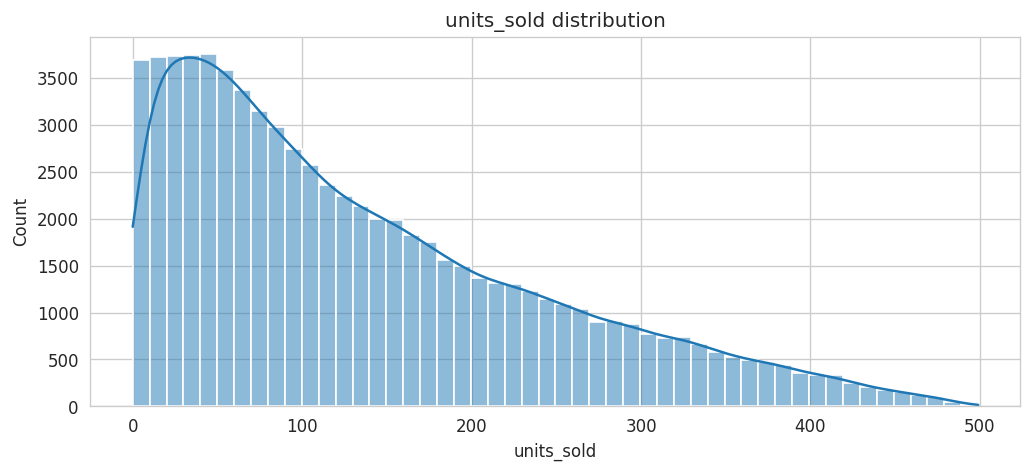

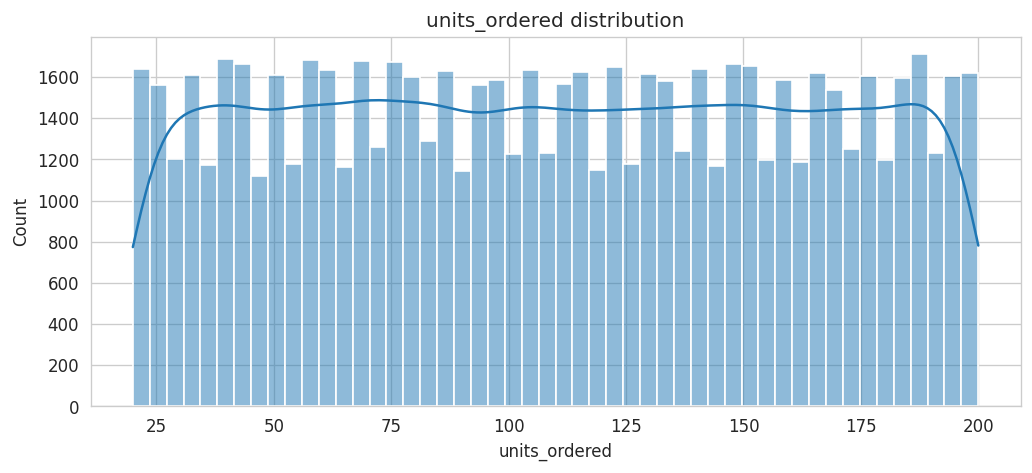

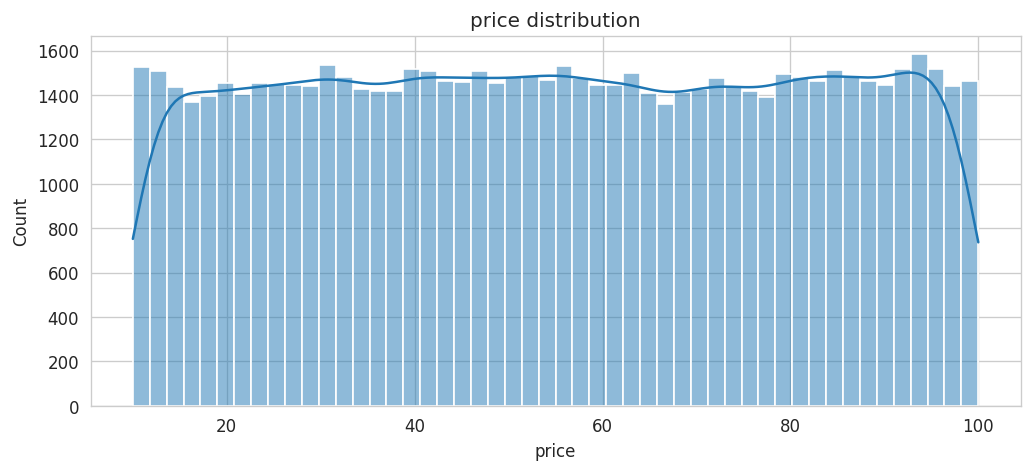

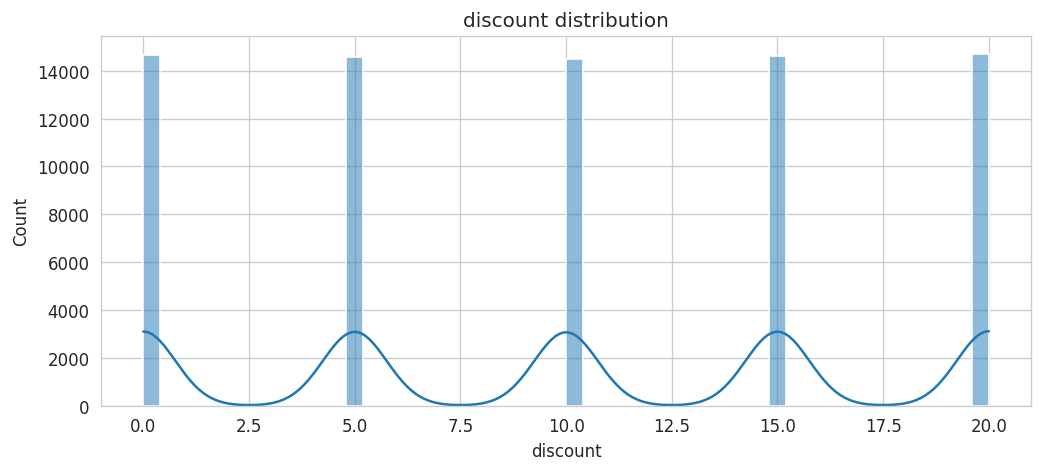

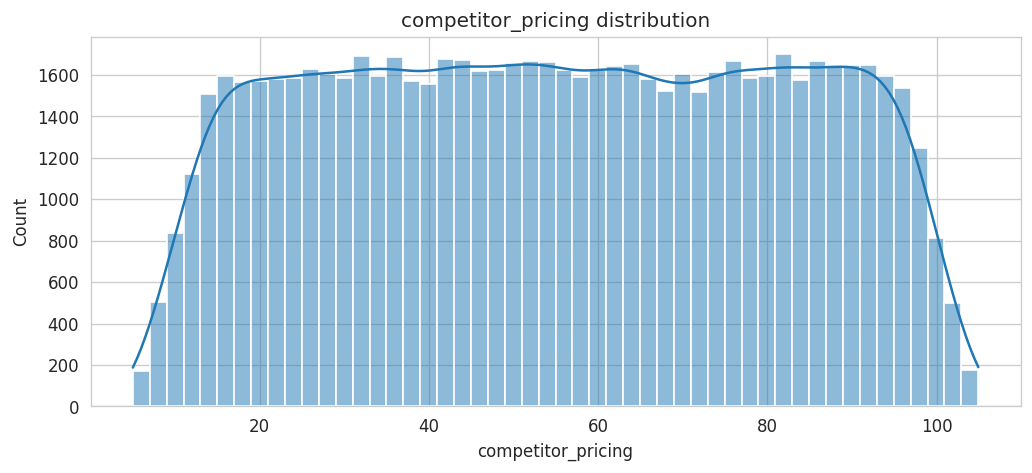

In [3]:
num_cols = ['units_sold',
       'units_ordered', 'price', 'discount', 'competitor_pricing']
display(df[num_cols].describe().T)

# Distribution plots
for col in num_cols:
    sns.histplot(df[col].dropna(), kde=True, bins=50)
    plt.title(f"{col} distribution")
    plt.show()

units_sold 
- berdistribusi right-skewed. Terdapat beberapa sales yang memiliki nilai tinggi
- **Action** : Check yang sales nya tinggi akibat promo/liburan

units_sold vs units_ordered
- units_sold max di 499 sedangkan units_ordered max di 200.
- **Action** : Cek ratio unit_sold/units_ordered > 1

price vs price_competitor
- Dari plotting untuk price vs price competitor tidak terlihat jauh berbeda
- **Action** : Tambahkan feature price_gap dan test korelasi dengan demand

# Rasio units_sold/units_ordered

In [4]:
# Hitung rasio sell_through
df["sell_through"] = df["units_sold"] / df["units_ordered"]

# Baris anomali: sell_through > 1
anomalous = df.query("sell_through > 1.0")
n_anom   = len(anomalous)
pct_anom = n_anom / len(df) * 100

print(f"{n_anom:,} baris (≈{pct_anom:.2f} %) memiliki sell_through > 1")


37,894 baris (≈51.84 %) memiliki sell_through > 1


In [5]:
# Tampilkan contoh 10 baris dengan rasio tertinggi
display(anomalous.sort_values("sell_through", ascending=False).head(10))


,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered,price,discount,weather_condition,holiday_promotion,competitor_pricing,seasonality,series_id,inventory_level_is_outlier,units_sold_is_outlier,units_ordered_is_outlier,price_is_outlier,discount_is_outlier,competitor_pricing_is_outlier,sell_through
72836,2023-04-13,S005,P0020,Electronics,South,491,467,20,53.92,5,Sunny,False,58.20,Summer,S005_P0020,False,True,False,False,False,False,23.350000
19685,2023-11-11,S002,P0007,Groceries,West,477,458,20,95.17,5,Rainy,False,99.37,Spring,S002_P0007,False,True,False,False,False,False,22.900000
59103,2023-09-16,S005,P0001,Toys,West,484,454,20,22.81,15,Sunny,True,25.61,Summer,S005_P0001,False,True,False,False,False,False,22.700000
35746,2023-10-21,S003,P0009,Groceries,South,469,452,20,35.99,15,Cloudy,False,35.59,Autumn,S003_P0009,False,True,False,False,False,False,22.600000
33681,2022-02-25,S003,P0007,Electronics,North,476,471,21,10.03,10,Snowy,False,12.06,Summer,S003_P0007,False,True,False,False,False,False,22.428571
14998,2023-01-14,S002,P0001,Groceries,South,485,445,20,33.87,5,Rainy,False,32.32,Spring,S002_P0001,False,False,False,False,False,False,22.250000
23420,2022-01-29,S002,P0013,Clothing,East,486,466,21,97.82,10,Snowy,True,95.29,Summer,S002_P0013,False,True,False,False,False,False,22.190476
34095,2023-04-15,S003,P0007,Electronics,North,445,443,20,30.07,0,Rainy,True,27.98,Summer,S003_P0007,False,False,False,False,False,False,22.150000
19149,2022-05-24,S002,P0007,Groceries,West,500,477,22,90.79,10,Sunny,False,93.51,Autumn,S002_P0007,False,True,False,False,False,False,21.681818
24080,2023-11-20,S002,P0013,Clothing,East,472,466,22,91.39,15,Cloudy,True,91.05,Spring,S002_P0013,False,True,False,False,False,False,21.181818


-  37 894 baris (≈ 51,8 %) menunjukkan `sell_through` > 1, artinya jumlah unit *terjual* melebihi unit *diorder* pada baris yang sama
- **Contoh ekstrem** mencapai rasio 23×
- **Action** : Fitur `units_ordered` mungkin tidak cukup kuat untuk memprediksi `units_sold`

# `price_gap` vs `unit_sold`

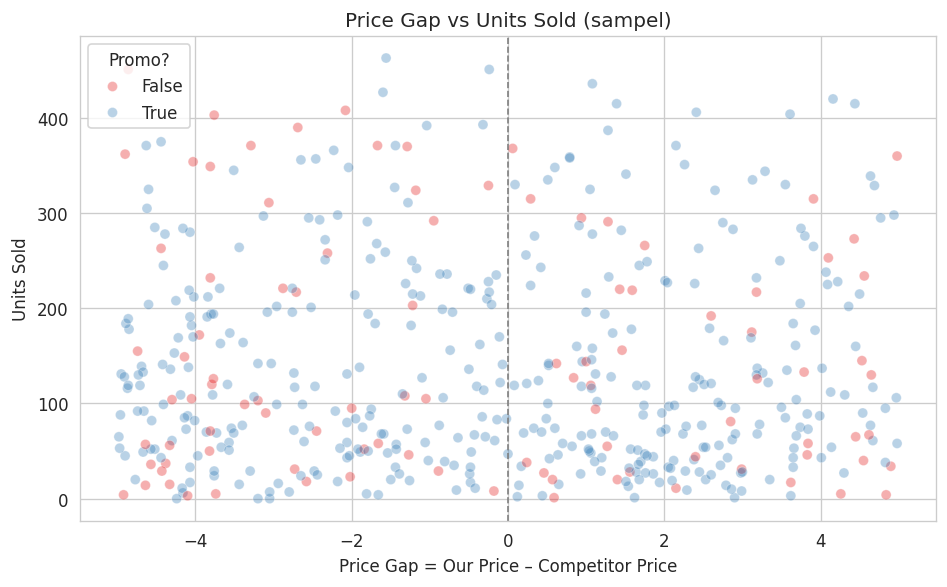

Korelasi Pearson price_gap vs units_sold: -0.002
Korelasi Pearson discount vs units_sold: 0.003


In [6]:
# Buat fitur price_gap & flag promo
df["price_gap"] = df["price"] - df["competitor_pricing"]
df["is_promo"]  = df["discount"] > 0   # Boolean flag

# Ambil sampel agar plot tetap ringan
SAMPLE_N = min(500, len(df))
plot_df  = df.sample(SAMPLE_N, random_state=42)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=plot_df,
    x="price_gap",
    y="units_sold",
    hue="is_promo",
    palette="Set1",
    alpha=0.35
)
plt.axvline(0, ls="--", lw=1, color="gray")
plt.title("Price Gap vs Units Sold (sampel)")
plt.xlabel("Price Gap = Our Price – Competitor Price")
plt.ylabel("Units Sold")
plt.legend(title="Promo?")
plt.tight_layout()
plt.show()

# Korelasi sederhana
corr = df[["price_gap", "units_sold"]].corr().iloc[0, 1]
print(f"Korelasi Pearson price_gap vs units_sold: {corr:.3f}")
corr = df[["discount", "units_sold"]].corr().iloc[0, 1]
print(f"Korelasi Pearson discount vs units_sold: {corr:.3f}")

- Tidak terlihat pola linear pada `price_gap` dan `unit_sold`(titik tersebar)
- Korelasi mendekati nilai 0 yang artinya tidak ada hubungan linear antara selisih harga dan jumlah terjual
- Titik warna biru (promo) dan merah (non-promo) terdistribusi acak, selain itu korelasi pearson `discount` & `unit_sold` mendekati titik 0 yang artinya tidak ada hubungan linear

# Zero Sales vs Stock Out

In [7]:
# Tandai baris bersalas 0
zero_sales = df["units_sold"] == 0
stockout   = (df["inventory_level"] == 0) & zero_sales
demand_zero = (df["inventory_level"] > 0) & zero_sales

print(f" Penjualan 0 total: {zero_sales.sum():,} baris")
print(f"   • Penjualan 0 + stok 0  : {stockout.sum():,} baris  ({stockout.mean()*100:.2f} %)")
print(f"   • Penjualan 0 + stok >0 : {demand_zero.sum():,} baris  ({demand_zero.mean()*100:.2f} %)")

# Tampilkan contoh baris
cols_show = ["date", "series_id", "units_sold", "inventory_level", "sell_through"]
display(df.loc[stockout].head(5))
display(df.loc[demand_zero].head(5))

 Penjualan 0 total: 360 baris
   • Penjualan 0 + stok 0  : 0 baris  (0.00 %)
   • Penjualan 0 + stok >0 : 360 baris  (0.49 %)


,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered,price,discount,weather_condition,holiday_promotion,competitor_pricing,seasonality,series_id,inventory_level_is_outlier,units_sold_is_outlier,units_ordered_is_outlier,price_is_outlier,discount_is_outlier,competitor_pricing_is_outlier,sell_through,price_gap,is_promo


,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered,price,discount,weather_condition,holiday_promotion,competitor_pricing,seasonality,series_id,inventory_level_is_outlier,units_sold_is_outlier,units_ordered_is_outlier,price_is_outlier,discount_is_outlier,competitor_pricing_is_outlier,sell_through,price_gap,is_promo
120,2022-05-01,S001,P0001,Groceries,North,125,0,117,36.91,10,Cloudy,False,37.85,Spring,S001_P0001,False,False,False,False,False,False,0.0,-0.94,True
251,2022-09-09,S001,P0001,Groceries,North,220,0,102,38.45,20,Sunny,True,39.51,Winter,S001_P0001,False,False,False,False,False,False,0.0,-1.06,True
492,2023-05-08,S001,P0001,Groceries,North,135,0,66,94.08,5,Sunny,False,91.55,Autumn,S001_P0001,False,False,False,False,False,False,0.0,2.53,True
605,2023-08-29,S001,P0001,Groceries,North,105,0,163,39.32,5,Rainy,False,40.58,Spring,S001_P0001,False,False,False,False,False,False,0.0,-1.26,True
887,2022-06-06,S001,P0002,Toys,South,72,0,117,95.64,15,Snowy,True,92.28,Spring,S001_P0002,False,False,False,False,False,False,0.0,3.36,True


- Semua penjualan 0 dikarenakan tidak ada demand (bukan stockout)

# Corellation Analysis

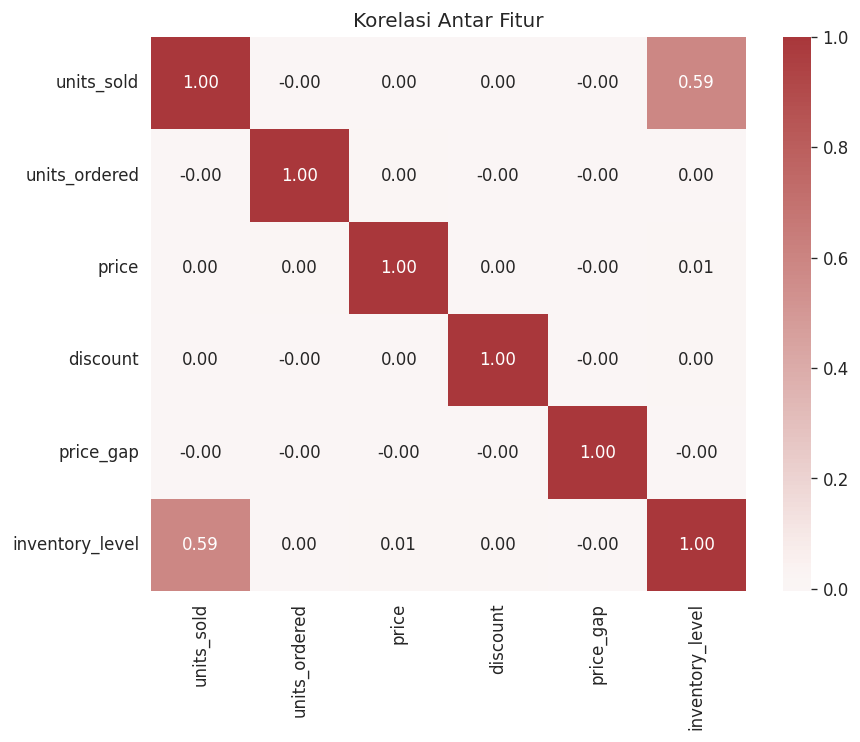

In [8]:
# Korelasi antar fitur
feat_cols = ["units_sold", "units_ordered", "price", "discount", "price_gap", "inventory_level"]
corr_feats = df[feat_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_feats, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Korelasi Antar Fitur")
plt.show()


- **`units_sold` vs `inventory_level` (r = 0.59)**  
  Terdapat korelasi positif cukup kuat antara inventory_level dan units_sold.  
  *notes:* Korelasi ini bisa timbul karena stok diatur berdasarkan permintaan historis, bukan stok yang memicu penjualan.

* **`units_sold` vs `price`, `discount`, `price_gap` (|r| < 0.05)**  
  Tidak ada korelasi linear antara units_sold terhadap price, discount dan price_gap

* **`units_sold` vs `units_ordered` (r ≈ 0)**  
  Tidak ada korelasi linier

In [9]:
# Untuk fitur categorical
def correlation_ratio(categories, values):
    cat = pd.Categorical(categories)
    y = np.asarray(values)
    grand_mean = y.mean()
    ss_between = sum(len(y[cat == k]) * (y[cat == k].mean() - grand_mean)**2
                     for k in cat.categories)
    ss_total   = ((y - grand_mean)**2).sum()
    return np.sqrt(ss_between / ss_total) if ss_total else 0.0

# hitung η untuk beberapa fitur kategori
for col in ["category", "region", "seasonality", 'weather_condition', 'holiday_promotion']:
    eta = correlation_ratio(df[col], df["units_sold"])
    print(f"η({col} ➜ units_sold) = {eta:.3f}")

η(category ➜ units_sold) = 0.006
η(region ➜ units_sold) = 0.005
η(seasonality ➜ units_sold) = 0.008
η(weather_condition ➜ units_sold) = 0.010
η(holiday_promotion ➜ units_sold) = 0.000


- Semua fitur categorical memiliki korelasi yang lemah terhadap `unit_sold`

# Time Series Plot

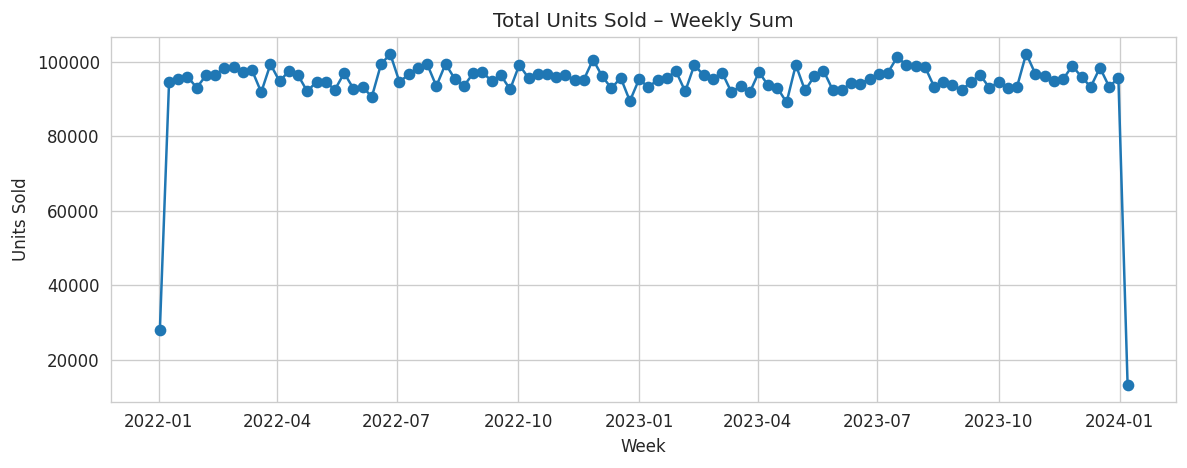

In [10]:
# Plot keseluruhan
weekly_total = (
    df.set_index('date')
      .resample('W')['units_sold']
      .sum()
)

plt.figure(figsize=(10, 4))
plt.plot(weekly_total.index, weekly_total.values, marker='o')
plt.title("Total Units Sold – Weekly Sum")
plt.xlabel("Week")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()

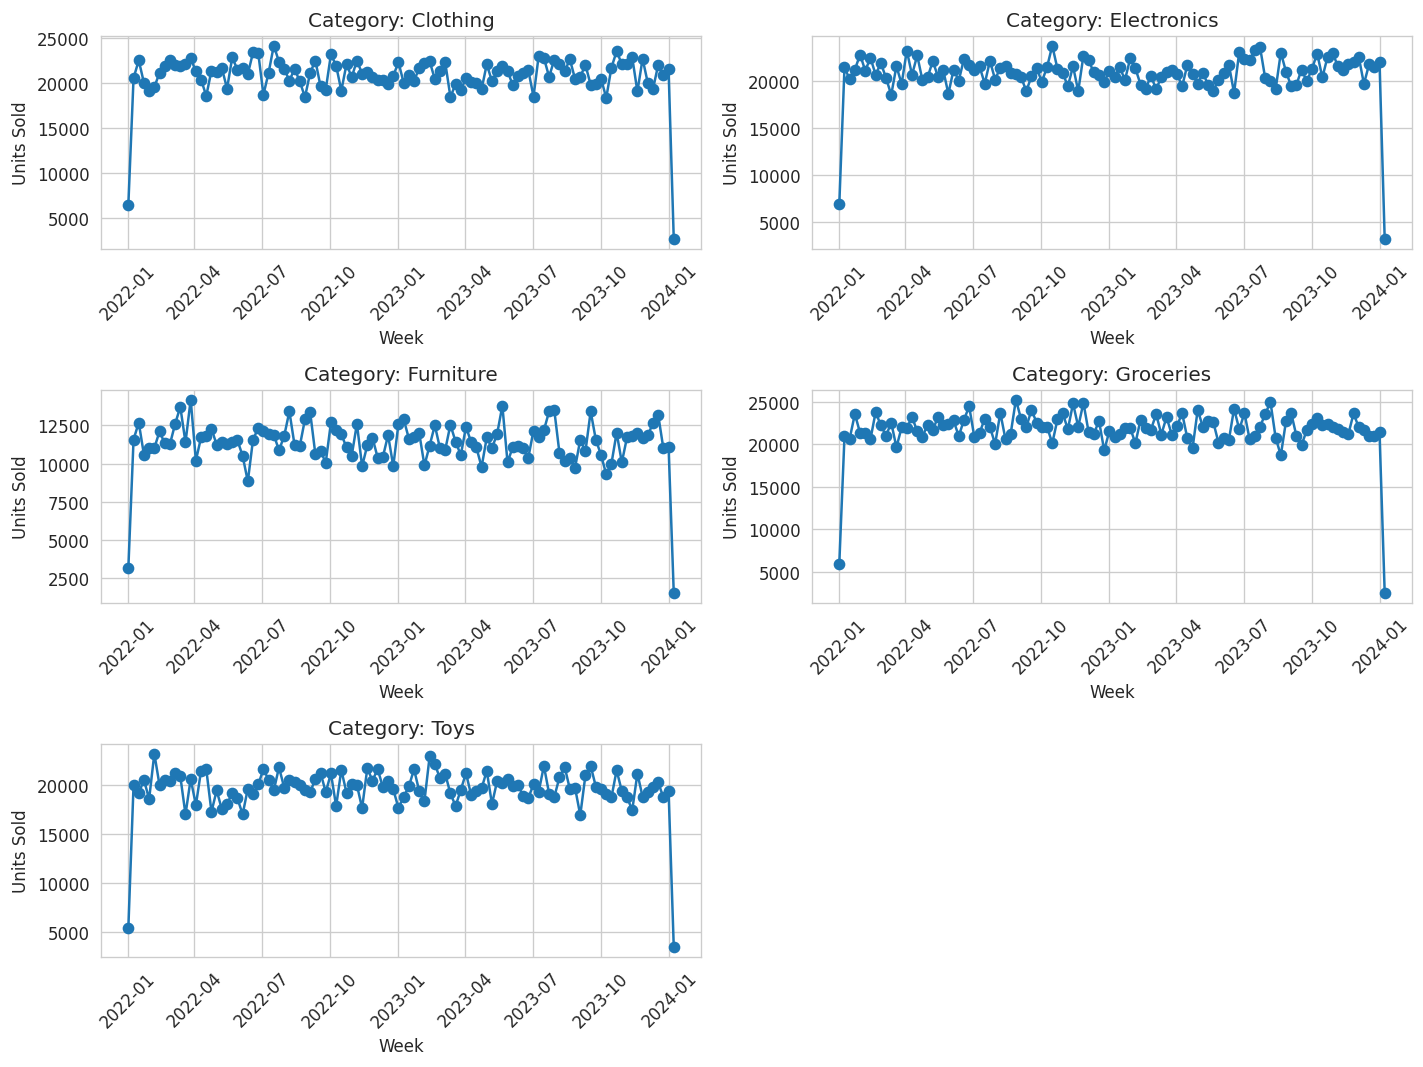

In [11]:
# plot per kategori
weekly_cat = (
    df.set_index('date')
      .groupby('category')['units_sold']
      .resample('W')
      .sum()
      .reset_index()
)

cats = weekly_cat['category'].unique()
n = len(cats)
cols = 2  
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3), sharey=False)
axes = axes.flatten()

for ax, cat in zip(axes, cats):
    subset = weekly_cat[weekly_cat['category'] == cat]
    ax.plot(subset['date'], subset['units_sold'], marker='o')
    ax.set_title(f"Category: {cat}")
    ax.set_xlabel("Week")
    ax.set_ylabel("Units Sold")
    ax.tick_params(axis='x', rotation=45)


for ax in axes[len(cats):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

- Pada minggu pertama 2022 dan minggu awal 2024 terdapat penurunan tajam <10K
- Volatilitas mingguan tidak tinggi


In [12]:
# Fungsi utk boxplot
def annotated_boxplot(data_list, labels, title, ylabel="Units Sold"):
    fig, ax = plt.subplots(figsize=(8, 5))
    bp = ax.boxplot(data_list, labels=labels, showfliers=False)
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_ylabel(ylabel)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    # Annotate medians
    medians = [np.median(d) for d in data_list]
    for i, median in enumerate(medians, start=1):
        ax.text(i, median, f"{median:,.0f}", ha='center', va='bottom', fontsize=9, weight='bold')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4129000/241557576.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, showfliers=False)


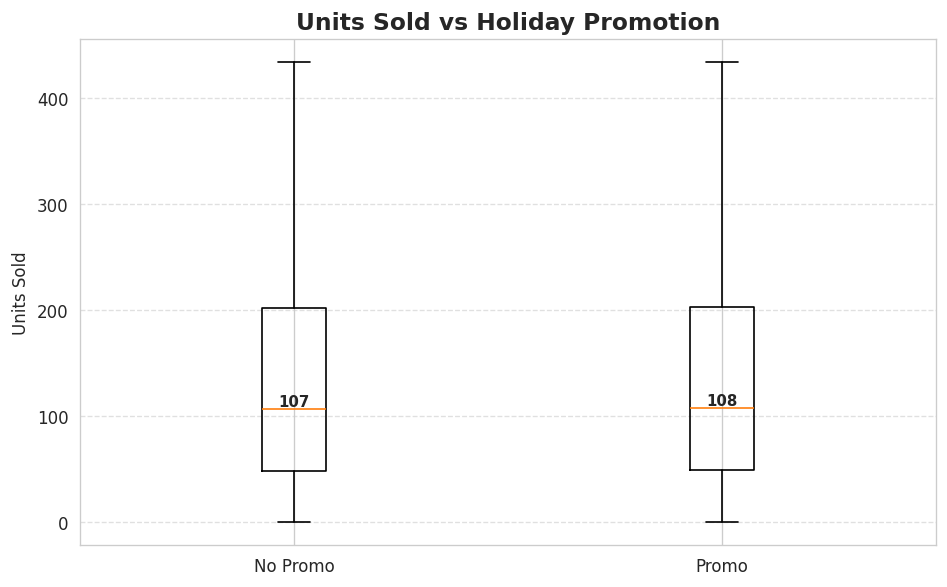

In [13]:
# holiday boxplot
holiday_labels = ['No Promo', 'Promo']
holiday_data = [
    df.loc[df['holiday_promotion'] == False, 'units_sold'],
    df.loc[df['holiday_promotion'] == True,  'units_sold']
]
annotated_boxplot(holiday_data, holiday_labels, "Units Sold vs Holiday Promotion")

/tmp/ipykernel_4129000/241557576.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, showfliers=False)


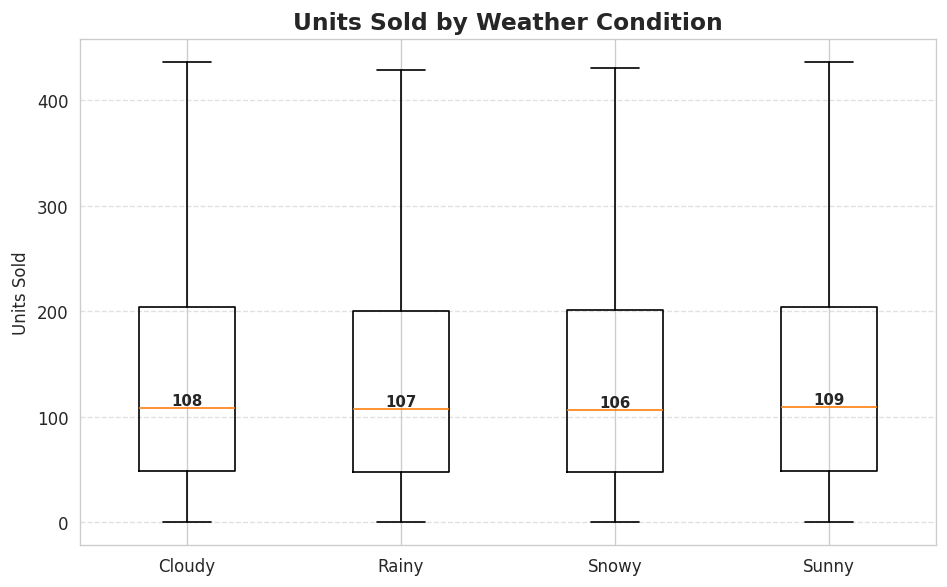

In [14]:
# Weather boxplot
weather_labels = sorted(df['weather_condition'].dropna().unique())
weather_data = [df.loc[df['weather_condition'] == w, 'units_sold'] for w in weather_labels]
annotated_boxplot(weather_data, weather_labels, "Units Sold by Weather Condition")

/tmp/ipykernel_4129000/241557576.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, showfliers=False)


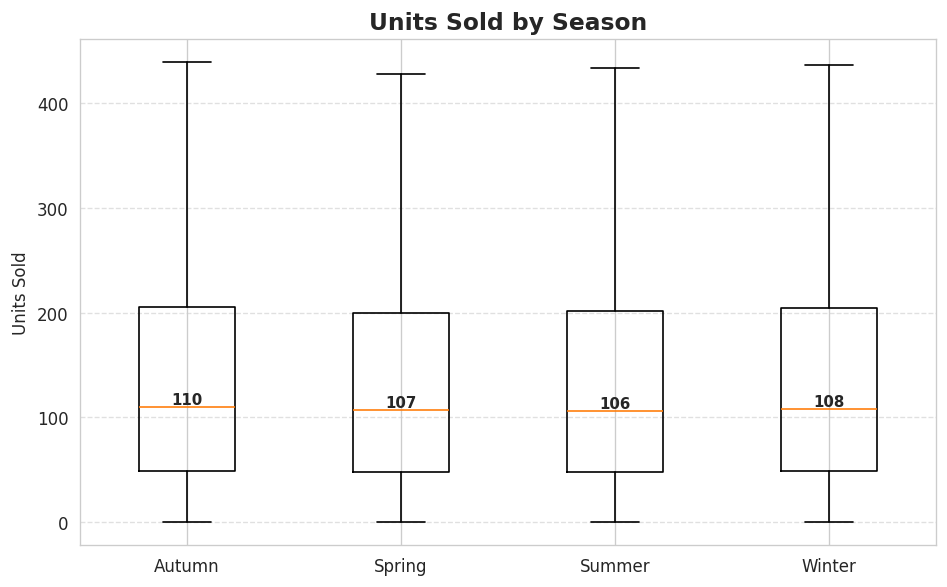

In [15]:
# Seasonality Boxplot
season_labels = sorted(df['seasonality'].dropna().unique())
season_data = [df.loc[df['seasonality'] == s, 'units_sold'] for s in season_labels]
annotated_boxplot(season_data, season_labels, "Units Sold by Season")

- Tidak ada perbedaan yang signifikan di masing2 kategori terhadap `units_sold`
- Dalam dataset ini, promo liburan, cuaca dan musim hanyalah weak signals

# Calendar heat-maps & seasonality

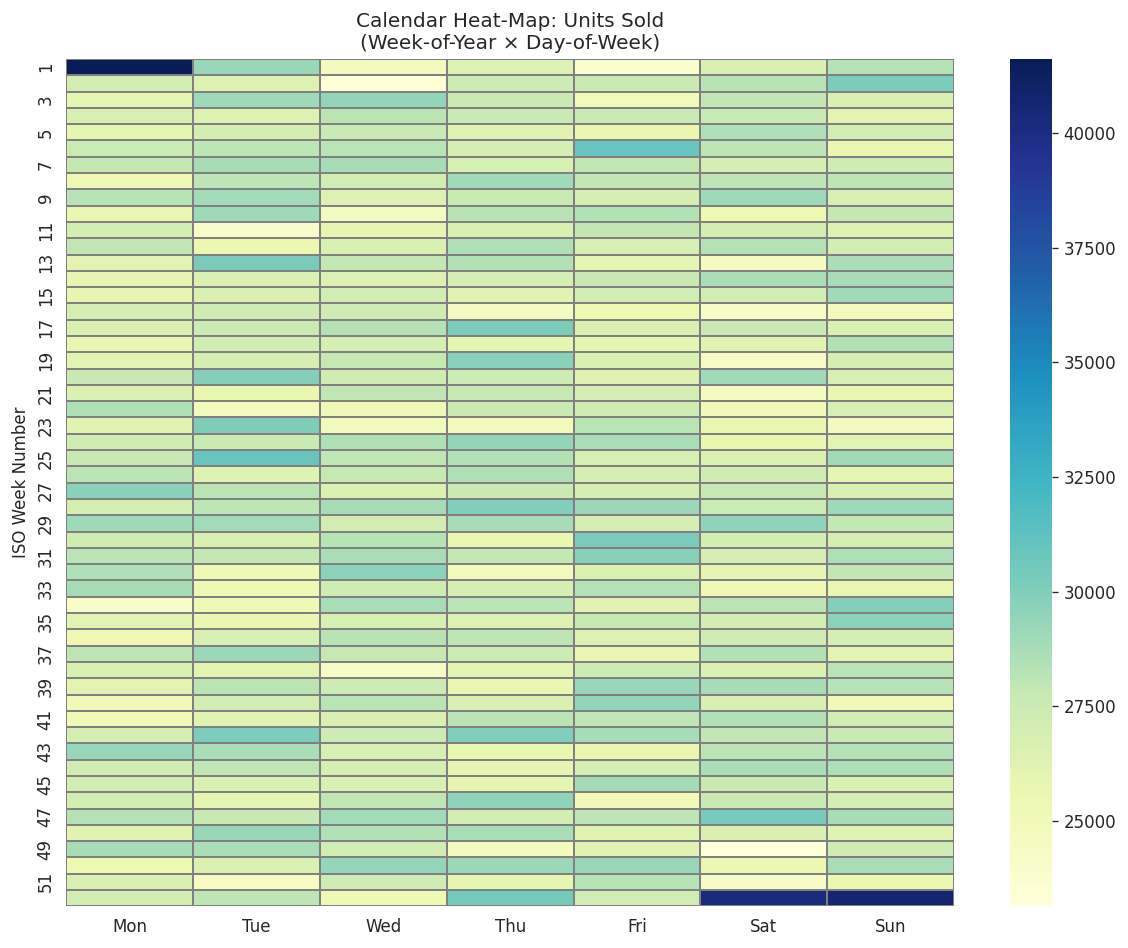

In [16]:
# Calendar Heat-Map (Day-of-Week × Week-of-Year)
agg_daily = df.groupby('date')['units_sold'].sum().reset_index()
agg_daily['dow']  = agg_daily['date'].dt.dayofweek   # 0=Mon
agg_daily['woy']  = agg_daily['date'].dt.isocalendar().week  # 1-53

pivot = agg_daily.pivot_table(
    index='woy', columns='dow', values='units_sold', aggfunc='sum'
).sort_index()

# Re-label columns to weekday names
pivot.columns = [calendar.day_abbr[d] for d in pivot.columns]

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.1, linecolor='gray')
plt.title("Calendar Heat-Map: Units Sold\n(Week-of-Year × Day-of-Week)")
plt.ylabel("ISO Week Number")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 1. Heat-map Week-of-Year × Day-of-Week
- Penjualan melonjak pada *Minggu ke-1 (Senin)* dan *Minggu 52/53* (pengujung tahun). Di minggu-minggu lain pola relatif stabil.  
- **Action**: Tambahkan fitur biner `is_new_year` (minggu 1) dan `is_year_end` (minggu 52-53).  


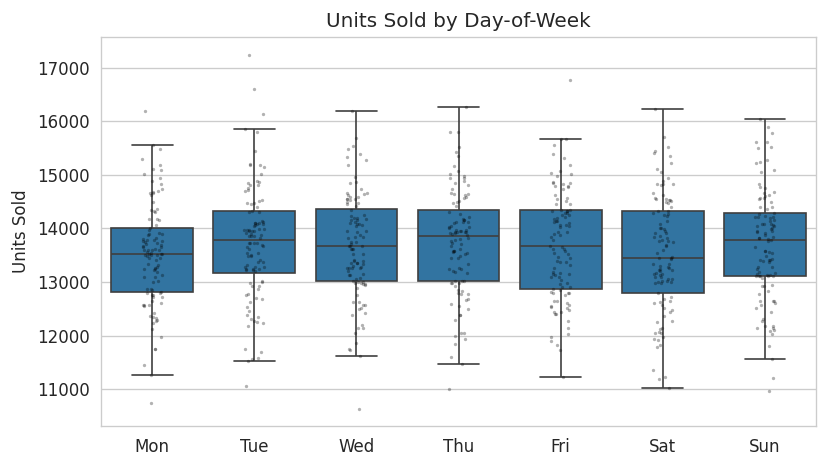

In [17]:
# Seasonality Strip: Daily Units Sold by Day-of-Week
plt.figure(figsize=(7, 4))
sns.boxplot(data=agg_daily, x='dow', y='units_sold', showfliers=False)
sns.stripplot(data=agg_daily, x='dow', y='units_sold', color='black', alpha=0.3, size=2)
plt.xticks(ticks=range(7), labels=[calendar.day_abbr[d] for d in range(7)])
plt.title("Units Sold by Day-of-Week")
plt.ylabel("Units Sold")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 2. Box/Strip Plot Day-of-Week
- Median penjualan naik perlahan dari Senin ke Sabtulalu turun tipis di Minggu. Varians terbesar terjadi di Jumat-Sabtu (banyak outlier tinggi).  
- **Action**:
  - Tambahkan flag `day_of_week`
  - Tambahkan flag `is_weekend`


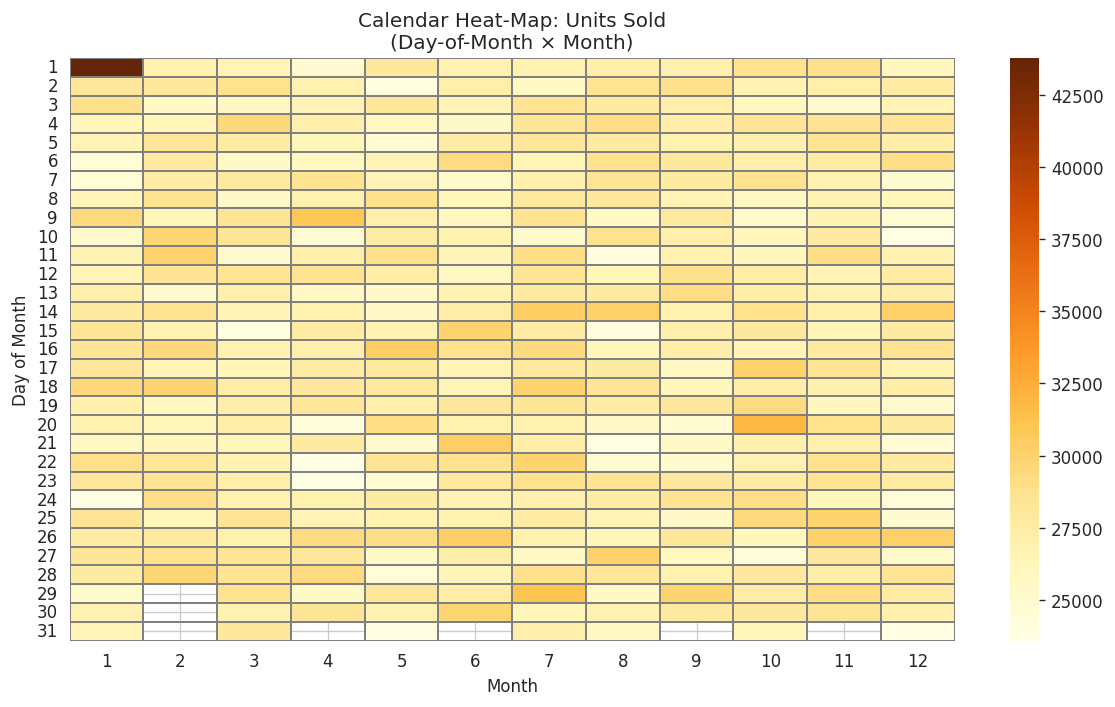

In [18]:
# Month × Day Heat-Map
agg_daily['month'] = agg_daily['date'].dt.month
agg_daily['dom']   = agg_daily['date'].dt.day   # day-of-month
pivot2 = agg_daily.pivot_table(
    index='dom', columns='month', values='units_sold', aggfunc='sum'
).sort_index()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot2, cmap='YlOrBr', linewidths=0.1, linecolor='gray')
plt.title("Calendar Heat-Map: Units Sold\n(Day-of-Month × Month)")
plt.ylabel("Day of Month")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

## 3. Heat-map Day-of-Month × Month
- Sales tertinggi pada **1 Januari** (> 40 k unit).  
- Hari 25-28 menunjukkan warna gelap (sedikit spike)  
- Hari 30-31 sering kosong (indikasi tidak ada transaksi atau data hilang)
- **Action**:
  - Buat fitur `is_new_year`, `weeknum`, dan `is_month_end`.  

In [19]:
# --- Calendar features ------------------------------------------------------
df['day_of_week']  = df['date'].dt.day_name()      # 'Monday', 'Tuesday', ...
df['is_weekend']   = df['date'].dt.dayofweek >= 5  # Sabtu=5, Minggu=6 → True
df['weeknum']      = df['date'].dt.isocalendar().week.astype(int)

df['is_month_end'] = df['date'].dt.is_month_end            # True pada 31/30/28/29
df['is_new_year']  = (df['date'].dt.month == 1)  & (df['date'].dt.day == 1)
df['is_year_end']  = (df['date'].dt.month == 12) & (df['date'].dt.day >= 25)

# Group-level summaries (Mean, median, cv, etc by group)

In [20]:
# Fungsi untuk generate stat desc per group
numeric_cols = ['inventory_level', 'units_sold', 'units_ordered', 'price', 'discount', 'competitor_pricing']
def summarize_group(df, keys, metrics):
    """Return group-level summary with mean, median, std, CV, min, max, count."""
    agg_dict = {}
    for col in metrics:
        agg_dict[col] = ["count", "mean", "median", "std", "min", "max"]
    out = (
        df.groupby(keys)
          .agg(agg_dict)
          .rename(columns={"std": "std_dev"})   # optional rename
    )
    # Flatten MultiIndex kolom → 'units_sold_mean', dst.
    out.columns = ["_".join(col).strip() for col in out.columns]
    
    # Tambahkan Coefficient of Variation (CV = std / mean)
    for col in metrics:
        out[f"{col}_cv"] = out[f"{col}_std_dev"] / out[f"{col}_mean"]
    
    return out.reset_index()
    
summary_df = summarize_group(df, ["series_id"], numeric_cols)

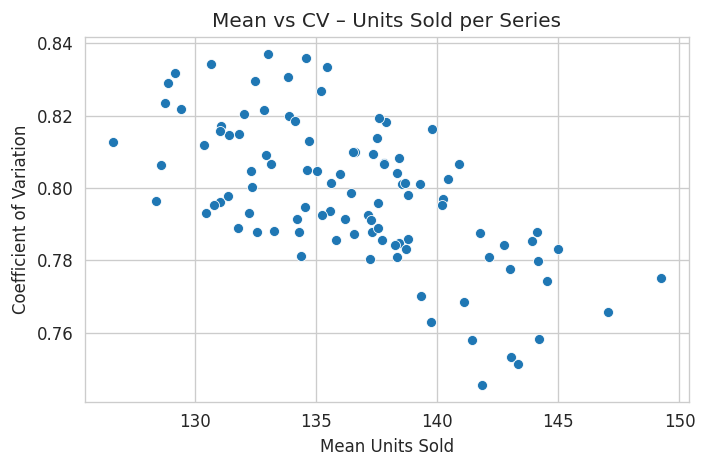

In [21]:
# Scatter mean vs CV untuk units_sold
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=summary_df,
    x='units_sold_mean',
    y='units_sold_cv'
)
plt.title('Mean vs CV – Units Sold per Series')
plt.xlabel('Mean Units Sold')
plt.ylabel('Coefficient of Variation')
plt.tight_layout()
plt.show()

Karena mean menunjukkan rata2 demand maka coba plot scatter vs CV untuk melihat "apakah product yang penjualan tinggi/rendah berpengaruh ke cv?"
-  Mean per series hanya 127 – 149 unit. Artinya volume dasar antar-SKU relatif setara
- Semua titik berada di CV ≈ 0,75 – 0,84. Jadi **tingkat volatilitas sama-sama tinggi**
- **Action** :Karena profil statistik hampir identik, pendekatan **pooling (shared model)** layak dicoba


# STL decomposition

STL singkatan dari Seasonal-Trend decomposition using Loess. Tujuannya memecah series menjadi Trend, Seasonal & Noise

In [22]:
# ---- STL SEMUA SKU --------------------------------
strength = []
for sid, grp in tqdm(df.groupby('series_id')):
    ts = (grp.set_index('date')
              .asfreq('D')['units_sold']
              .interpolate('linear'))

    res = STL(ts, period=7, robust=True).fit()
    trend_str  = 1 - (res.resid.var() / (res.trend + res.resid).var())
    seas_str   = 1 - (res.resid.var() / (res.seasonal + res.resid).var())
    strength.append({"series_id": sid,
                     "trend_strength": trend_str,
                     "seasonal_strength": seas_str})

stl_stats = pd.DataFrame(strength)

100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


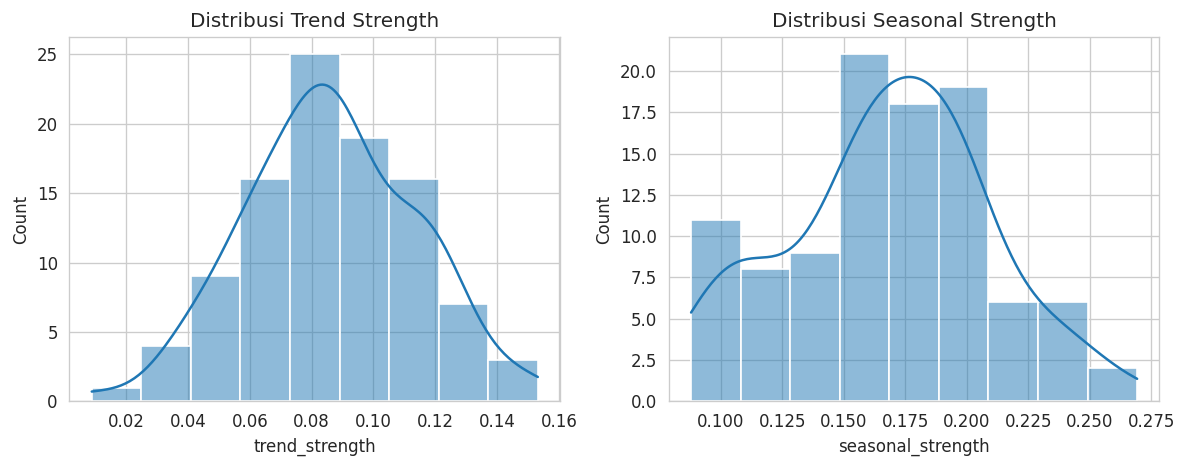

In [23]:
# Visualisasi trend & seasonal
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(stl_stats['trend_strength'], kde=True, ax=ax[0])
ax[0].set_title('Distribusi Trend Strength')
sns.histplot(stl_stats['seasonal_strength'], kde=True, ax=ax[1])
ax[1].set_title('Distribusi Seasonal Strength')
plt.tight_layout()
plt.show()

- **Trend Strength**  
  - Nilai berkisar 0 – 0,16
  - Artinya hampir semua series tidak memiliki tren jangka panjang yang kuat

- **Seasonal Strength (weekly)**  
  - Nilai berkisar 0,15 – 0,20
  - Menunjukkan weekly seasonality yang lemah


# Stationary Test

Stationary adalah kondisi dimana stat desc series sepanjang waktu tetap. Stationary test digunakan untuk menentukan apakah series tersebut memiliki stat desc yang sama sepanjang waktu.

In [24]:
# fungsi adf dan kpss
def adf_test(series, maxlag=None):
    """Return p-value dari ADF."""
    result = adfuller(series.dropna(), maxlag=maxlag, autolag='AIC')
    return result[1]   # p-value

def kpss_test(series, regression='c', nlags='auto'):
    """Return p-value dari KPSS."""
    result = kpss(series.dropna(), regression=regression, nlags=nlags)
    return result[1]   # p-value


In [25]:
# Batch test seluruh SKU
records = []
for sid, grp in tqdm(df.groupby('series_id')):
    ts = (grp.set_index('date')
              .asfreq('D')['units_sold']
              .interpolate('linear'))
    records.append({
        'series_id'     : sid,
        'adf_pvalue'    : adf_test(ts),
        'kpss_pvalue'   : kpss_test(ts)
    })

stationary_df = pd.DataFrame(records)

# Flag hasil: stasioner bila ADF < 0.05 & KPSS >= 0.05
stationary_df['is_stationary'] = (
    (stationary_df['adf_pvalue']  < 0.05) &
    (stationary_df['kpss_pvalue'] >= 0.05)
)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_4129000/3476307650.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags=nlags)
/tmp/ipykernel_4129000/3476307650.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags=nlags)
  2%|▏         | 2/100 [00:00<00:05, 16.44it/s]/tmp/ipykernel_4129000/3476307650.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags=nlags)
/tmp/ipykernel_4129000/3476307650.py:9: InterpolationWarning: The test statistic is ou

In [26]:
# Summary
print(stationary_df['is_stationary'].value_counts())
display(stationary_df.head())

is_stationary
True     93
False     7
Name: count, dtype: int64


,series_id,adf_pvalue,kpss_pvalue,is_stationary
0,S001_P0001,0.000000e+00,0.10,True
1,S001_P0002,0.000000e+00,0.01,False
2,S001_P0003,0.000000e+00,0.10,True
3,S001_P0004,0.000000e+00,0.10,True
4,S001_P0005,1.270587e-08,0.10,True


# Time Series Clustering

Series clustering digunakan untuk mengelompokkan series yang memiliki kemiripan. Hal ini berguna saat modeling sebagai contoh jika training local model maka tidak perlu train model per series tapi bisa disederhanakan menjadi training per cluster

In [27]:
# Merge summary_df, stl_stats, stationary_df
feature_df = summary_df.merge(stl_stats, how = "left", on = "series_id").merge(stationary_df, how = "left", on = "series_id")

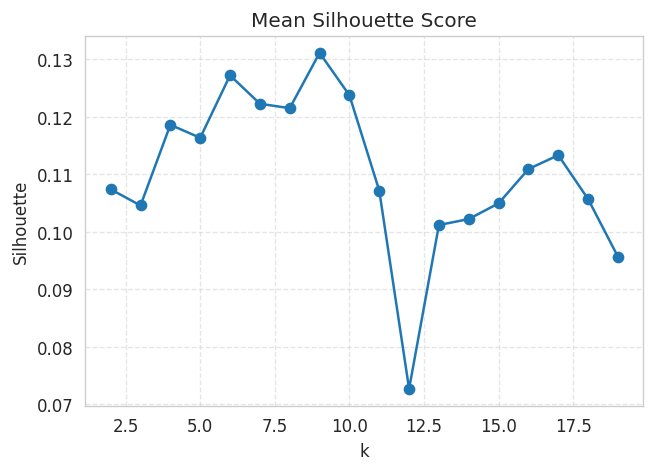

Best K based on Silhouette: 9


In [28]:
# Filter kolom yang dibutuhkan untuk clustering
clustering_features = [ 'units_sold_mean', 'units_sold_median', 'units_sold_std_dev',
       'units_sold_min', 'units_sold_max', 'price_mean',
       'price_median', 'price_std_dev', 'price_min', 'price_max', 'units_sold_cv', 'price_cv', 'trend_strength',
       'seasonal_strength', 'adf_pvalue', 'kpss_pvalue']
X = feature_df[clustering_features].values

# Normalisasi
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Tetapkan jumlah cluster
K_range = range(2, 20)
inertia  = []
silh     = []

for k in K_range:
    km  = KMeans(n_clusters=k, n_init='auto', random_state=42)
    lbl = km.fit_predict(X_std)
    silh.append(silhouette_score(X_std, lbl))


# Plot Silhouette
plt.figure(figsize=(6,4))
plt.plot(K_range, silh, marker='o')
plt.title("Mean Silhouette Score")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True, ls='--', alpha=.5)
plt.show()

best_k = int(np.argmax(silh)) + 2   # +2 karena range mulai di 2
print(f"Best K based on Silhouette: {best_k}")

In [29]:
# clustering
k = best_k     
kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
labels = kmeans.fit_predict(X_std)

feature_df['cluster'] = labels
centroids = scaler.inverse_transform(kmeans.cluster_centers_)  # balik skala

In [30]:
# Stat per cluster
cluster_stats = (
    feature_df.groupby('cluster')[clustering_features]
              .agg(['count', 'mean'])
              .round(2)
)
display(cluster_stats)

units_sold_mean         units_sold_median         units_sold_std_dev  \
                  count    mean             count    mean              count   
cluster                                                                        
0                    14  140.47                14  113.14                 14   
1                    18  134.15                18  104.00                 18   
2                    19  135.86                19  107.53                 19   
3                    12  132.17                12  103.58                 12   
4                     9  135.52                 9  106.89                  9   
5                     3  141.30                 3  111.67                  3   
6                    13  133.91                13  101.69                 13   
7                    11  143.66                11  118.27                 11   
8                     1  133.13                 1  104.00                  1   

                units_sold_min      units_sold_max         price_mean         \
           mean          count mean          count    mean      count   mean   
cluster                                                                        
0        110.42             14  0.0             14  478.43         14  54.21   
1        108.80             18  0.0             18  481.28         18  54.63   
2        108.04             19  0.0             19  479.47         19  56.25   
3        105.57             12  0.0             12  463.33         12  55.26   
4        108.27              9  0.0              9  480.22          9  55.03   
5        109.74              3  1.0              3  480.00          3  53.45   
6        110.33             13  0.0             13  482.85         13  55.28   
7        110.64             11  0.0             11  479.45         11  55.56   
8        107.37              1  0.0              1  480.00          1  53.89   

        price_median        price_std_dev        price_min        price_max  \
               count   mean         count   mean     count   mean     count   
cluster                                                                       
0                 14  53.25            14  26.17        14  10.16        14   
1                 18  54.22            18  25.98        18  10.13        18   
2                 19  56.63            19  25.82        19  10.12        19   
3                 12  55.11            12  26.27        12  10.10        12   
4                  9  54.95             9  25.94         9  10.08         9   
5                  3  52.74             3  25.86         3  10.05         3   
6                 13  55.39            13  26.03        13  10.09        13   
7                 11  55.69            11  26.10        11  10.10        11   
8                  1  52.96             1  25.60         1  10.08         1   

               units_sold_cv       price_cv       trend_strength        \
          mean         count  mean    count  mean          count  mean   
cluster                                                                  
0        99.80            14  0.79       14  0.48             14  0.07   
1        99.72            18  0.81       18  0.48             18  0.10   
2        99.90            19  0.80       19  0.46             19  0.08   
3        99.91            12  0.80       12  0.48             12  0.10   
4        99.80             9  0.80        9  0.47              9  0.10   
5        99.78             3  0.78        3  0.48              3  0.10   
6        99.96            13  0.82       13  0.47             13  0.06   
7        99.87            11  0.77       11  0.47             11  0.10   
8        99.95             1  0.81        1  0.47              1  0.03   

        seasonal_strength       adf_pvalue      kpss_pvalue        
                    count  mean      count mean       count  mean  
cluster                                                            
0                      14  0.17         14  

**Jumlah cluster terbentuk: 9**  
Namun rentang stats descriptive antar-cluster sempit ⇒ segmentasi *lemah*


* **Ukuran klaster timpang**  
  - Terbesar: **Cluster 2 (19 SKU)**, **Cluster 1 (18 SKU)**  
  - Terkecil: **Cluster 8 (1 SKU)**, **Cluster 5 (3 SKU)** ⇒ kandidat outlier


In [31]:
# Export to parquet
feature_df.to_parquet("data/preprocessed/stats_series.parquet", index = False)
df.to_parquet("data/preprocessed/df_feature.parquet", index = False)